<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/Combination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Epoch 0: 0.5787081741230983
Epoch 1: 0.5751900794110155
Epoch 2: 0.5737187810478408
Epoch 3: 0.5704224362951176
Epoch 4: 0.568618426981177
Epoch 5: 0.5659860038509572
Epoch 6: 0.564445891548456
Epoch 7: 0.5623051252823849
Epoch 8: 0.5591318699640461
Epoch 9: 0.5594806432861358
Epoch 10: 0.5552166577324066
Epoch 11: 0.5529780036300748
Epoch 12: 0.5517736382029359
Epoch 13: 0.5484923017460608
Epoch 14: 0.546832600721066
Epoch 15: 0.5433891096281827
Epoch 16: 0.5393206213351674
Epoch 17: 0.5395930070881351
Epoch 18: 0.5377718360064051
Epoch 19: 0.5338678373741883
Epoch 20: 0.5319690606381273
Epoch 21: 0.5291200743711141
Epoch 22: 0.5262868674858288
Epoch 23: 0.5241951085770251
Epoch 24: 0.5216158297583063
Epoch 25: 0.5194828326387428
Epoch 26: 0.5158889268437651
Epoch 27: 0.5136201201499762
Epoch 28: 0.5103543853389719
Epoch 29: 0.5081201061843621
Epoch 30: 0.5055759180716789
Epoch 31: 0.5029975030601972
Epoch 32: 0.4995833836789566
Epoch 33: 0.4977710633354862
Epoch

NameError: ignored

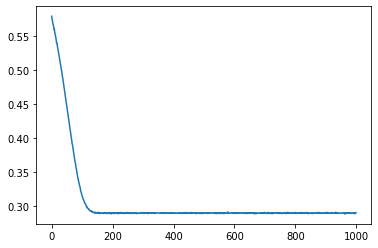

In [4]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
dim1 = len(trimmed_specs)

typed_trimmed_specs = List()
[typed_trimmed_specs.append(x) for x in trimmed_specs]

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm, tolerance):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                # m = mult[i*dim1+j]
                ar[i][j] = r
                ar[j][i] = (1-r)

    return ar

def datagen():
    lm = generate_matrix(typed_trimmed_specs, 0)
    cm = predict_community_fullnp(lm, trimmed_specs, verb=False)
    return (cm, get_LT(lm))

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
	print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, 462*5)
        self.fc2 = nn.Linear(462*5, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = MyNet().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=1e-4)

loss_v = []

for i in range(10000):
    optimizer.zero_grad()
    x, y = datagen()
    input = torch.from_numpy(x).float().to(device)
    true_y = torch.FloatTensor(y).to(device)

    output = net(input).to(device)

    loss = criterion(output, true_y).to(device)
    loss_v.append(sqrt(loss.item()))
    loss.backward()

    optimizer.step()

    print(f'Epoch {i}: {sqrt(loss.item())}')

for i in range(100):
  print(f'Test Epoch {i}')
  test_loss = 0
  x, y = datagen()
  test_x = torch.from_numpy(x).float().to(device)
  test_y = torch.FloatTensor(y).to(device)

  output = net(input).to(device)

  loss = criterion(output, true_y).to(device)
  test_loss += sqrt(loss.item())
  print(f'Average Test RMS: {test_loss/100}')

PATH = 'model.pth'
torch.save(net.state_dict(), PATH)

plt.plot(loss_v)
plt.savefig('Loss.png')
plt.show()
